In [1]:
#Importing the dependencies
import os
import duckdb as ddb
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px
import pytz
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
import joblib
from arch import arch_model
from statsmodels.stats.diagnostic import acorr_ljungbox
from scipy.stats import t as t_dist
from sklearn.metrics import mean_squared_error, mean_absolute_error
import scipy.stats as stats
from statsmodels.tsa.stattools import acf

In [2]:
#Create a connection to DuckDB database
conn = ddb.connect(r"..\nakuru_air_quality.db")

In [3]:
#Create a new dataframe with data from the DuckDB database
location_id = 1894637
df = conn.query(f"""
SELECT *
FROM nakuru.air_quality_data
WHERE parameter = 'pm25'
AND location_id = {location_id}
""").to_df()
df.head()

,location_id,sensors_id,location,datetime,lat,lon,parameter,units,value,month,year,ingenstion_datetime
0,1894637,7466385,Nakuru-1864771,2025-01-01 00:16:09,-0.2674,36.0218,pm25,µg/m³,11.12,01,2025,2025-11-29 09:45:36.141245
1,1894637,7466385,Nakuru-1864771,2025-01-01 00:33:21,-0.2674,36.0218,pm25,µg/m³,8.2,01,2025,2025-11-29 09:45:36.141245
2,1894637,7466385,Nakuru-1864771,2025-01-01 00:50:33,-0.2674,36.0218,pm25,µg/m³,10.67,01,2025,2025-11-29 09:45:36.141245
3,1894637,7466385,Nakuru-1864771,2025-01-01 01:08:13,-0.2674,36.0218,pm25,µg/m³,11.14,01,2025,2025-11-29 09:45:36.141245
4,1894637,7466385,Nakuru-1864771,2025-01-01 01:25:24,-0.2674,36.0218,pm25,µg/m³,14.94,01,2025,2025-11-29 09:45:36.141245


In [4]:
#Dataframe structure
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56118 entries, 0 to 56117
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   location_id          56118 non-null  int64         
 1   sensors_id           56118 non-null  int64         
 2   location             56118 non-null  object        
 3   datetime             56118 non-null  datetime64[us]
 4   lat                  56118 non-null  float64       
 5   lon                  56118 non-null  float64       
 6   parameter            56118 non-null  object        
 7   units                56118 non-null  object        
 8   value                56118 non-null  object        
 9   month                56118 non-null  object        
 10  year                 56118 non-null  int64         
 11  ingenstion_datetime  56118 non-null  datetime64[us]
dtypes: datetime64[us](2), float64(2), int64(3), object(5)
memory usage: 5.1+ MB


In [5]:
#Memory usage per column
total_mem = 0
for col in df.columns:
    mem = df[col].memory_usage(deep=True) / 1e6
    total_mem += mem
    print(f"Column: {col} | Memory Usage: {mem:.4f} MB")
    print("---" * 30)
print(f"Total Memory Usage of entire DataFrame {total_mem} MB")

Column: location_id | Memory Usage: 0.4491 MB
------------------------------------------------------------------------------------------
Column: sensors_id | Memory Usage: 0.4491 MB
------------------------------------------------------------------------------------------
Column: location | Memory Usage: 3.5356 MB
------------------------------------------------------------------------------------------
Column: datetime | Memory Usage: 0.4491 MB
------------------------------------------------------------------------------------------
Column: lat | Memory Usage: 0.4491 MB
------------------------------------------------------------------------------------------
Column: lon | Memory Usage: 0.4491 MB
------------------------------------------------------------------------------------------
Column: parameter | Memory Usage: 2.9744 MB
------------------------------------------------------------------------------------------
Column: units | Memory Usage: 3.9284 MB
--------------------------

In [6]:
#Summary statistics
df.describe()

,location_id,sensors_id,datetime,lat,lon,year,ingenstion_datetime
count,56118.0,56118.0,56118,5.611800e+04,5.611800e+04,56118.0,56118
mean,1894637.0,7466385.0,2025-06-21 23:51:48.855162,-2.674000e-01,3.602180e+01,2025.0,2025-12-08 16:38:49.971240
min,1894637.0,7466385.0,2024-12-31 21:16:09,-2.674000e-01,3.602180e+01,2025.0,2025-11-29 09:45:36.141245
25%,1894637.0,7466385.0,2025-03-25 21:00:46.250000,-2.674000e-01,3.602180e+01,2025.0,2025-11-29 09:45:36.141245
50%,1894637.0,7466385.0,2025-06-30 13:33:22,-2.674000e-01,3.602180e+01,2025.0,2025-12-04 10:00:43.873596
75%,1894637.0,7466385.0,2025-09-15 17:23:09.250000,-2.674000e-01,3.602180e+01,2025.0,2025-12-21 09:56:49.800000
max,1894637.0,7466385.0,2025-12-17 20:51:54,-2.674000e-01,3.602180e+01,2025.0,2025-12-21 09:56:49.800000
std,0.0,0.0,NaN,2.328714e-13,1.139010e-11,0.0,NaN


In [7]:
#Categorical features Summary Statistics
df.describe(include="O")

,location,parameter,units,value,month
count,56118,56118,56118,56118,56118
unique,1,1,1,5163,12
top,Nakuru-1864771,pm25,µg/m³,0.0,08
freq,56118,56118,56118,1371,5970


In [8]:
#Rename 'ingenstion' column
df.rename(columns={"ingenstion_datetime": "ingestion_datetime"}, inplace=True)
df.columns

Index(['location_id', 'sensors_id', 'location', 'datetime', 'lat', 'lon',
       'parameter', 'units', 'value', 'month', 'year', 'ingestion_datetime'],
      dtype='object')

In [9]:
#Ensure both date columns are datetime types
df['datetime'] = pd.to_datetime(df['datetime'], errors="coerce")
df['ingestion_datetime'] = pd.to_datetime(df['ingestion_datetime'], errors="coerce")

#Set measurement datetime as index
df.set_index('datetime', inplace=True)

In [10]:
#view the first 5 datetimes
df.index[:5]

DatetimeIndex(['2025-01-01 00:16:09', '2025-01-01 00:33:21',
               '2025-01-01 00:50:33', '2025-01-01 01:08:13',
               '2025-01-01 01:25:24'],
              dtype='datetime64[us]', name='datetime', freq=None)

The timestamps are not sorted. That’s why the first 5 entries look out of order: 02:00, 01:00, 23:00, etc.

For a time series model, our indices need to be sorted chronologically.

In [11]:
#Sort the dataframe by the datetime index
df = df.sort_index()

#View the first 5 timestamps after sorting
df.index[:5]

DatetimeIndex(['2024-12-31 21:16:09', '2024-12-31 21:33:21',
               '2024-12-31 21:50:33', '2024-12-31 22:08:13',
               '2024-12-31 22:25:24'],
              dtype='datetime64[us]', name='datetime', freq=None)

In [12]:
#Check if datetimes are current timezone-naive
print(df.index.tz)

None


In [13]:
#Convert to Kenyan time(Africa/Nairobi)
df.index = df.index.tz_localize('UTC').tz_convert('Africa/Nairobi')
df['ingestion_datetime'] = (
    df['ingestion_datetime']
      .dt.tz_localize('UTC') 
      .dt.tz_convert('Africa/Nairobi')
)

In [14]:
#Convert 'value' column to numeric
df['value'] = pd.to_numeric(df['value'], errors='coerce')

#Check for null entries
df['value'].isna().sum()

np.int64(0)

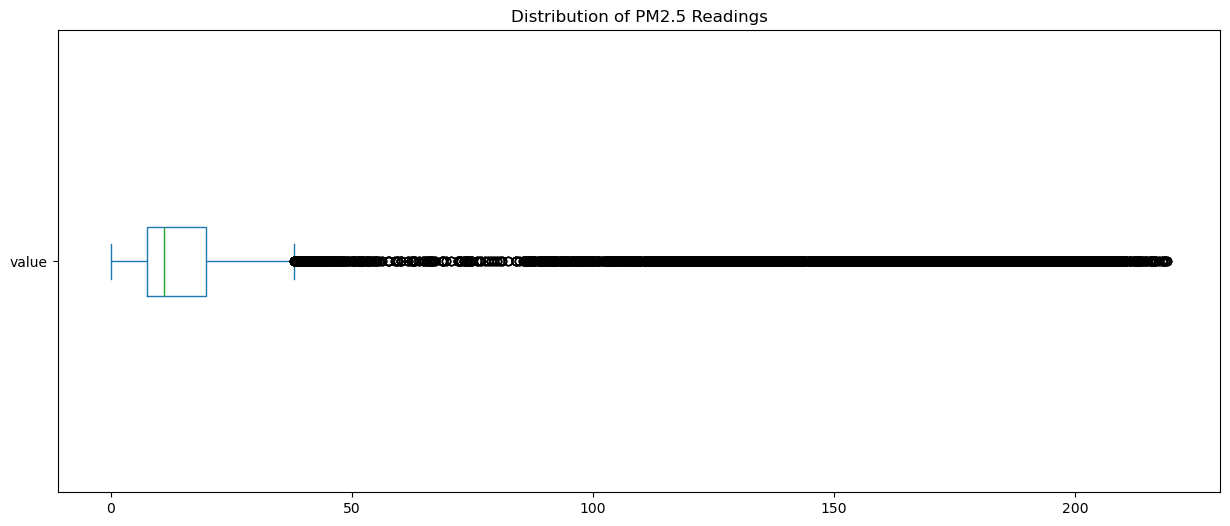

In [15]:
#BoxPlot to check for outliers
fig, ax = plt.subplots(figsize=(15, 6))
df["value"].plot(kind="box", vert=False, title="Distribution of PM2.5 Readings", ax=ax);


Air Quality Index & Associated Health Impacts

Good (0–50): Minimal Impact

Satisfactory (51–100): May cause minor breathing discomfort to sensitive people.

Moderately polluted (101–200): May cause breathing discomfort to people with lung disease such as asthma, and discomfort to people with heart disease, children and older adults.

Poor (201–300): May cause breathing discomfort to people on prolonged exposure, and discomfort to people with heart disease

Very Poor (301–400): May cause respiratory illness to the people on prolonged exposure. Effect may be more pronounced in people with lung and heart diseases.

Severe (401-500): May cause respiratory impact even on healthy people, and serious health impacts on people with lung/heart disease. The health impacts may be experienced even during light physical activity.

In [16]:
#Filter data where 'pm2.5' is greater than 500(Severe) & less than 0
df = df[(df["value"] > 0) & (df["value"] <= 500)]

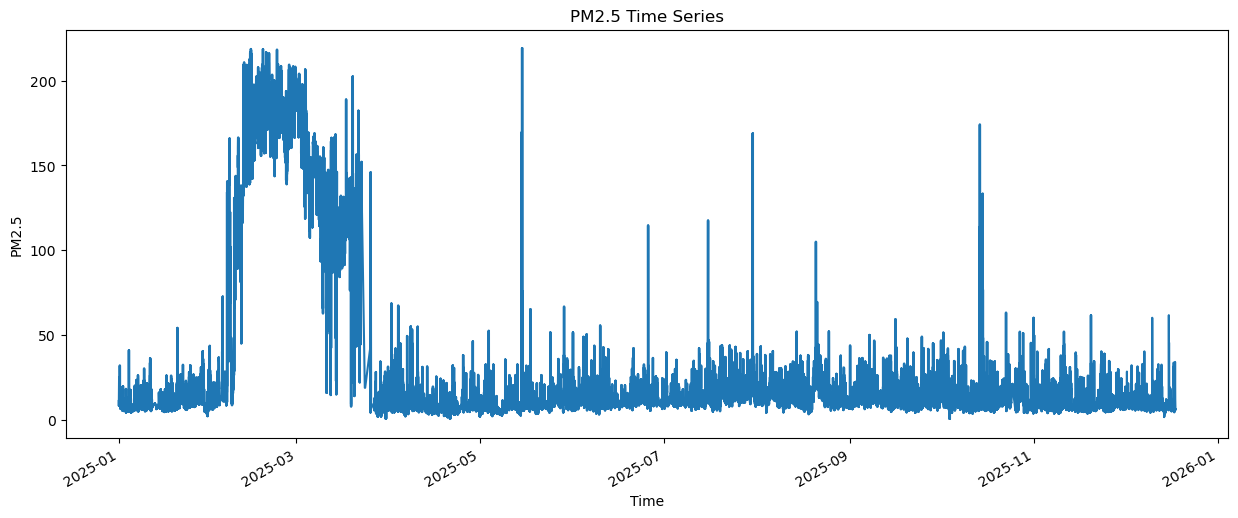

In [17]:
#Create a pm2.5 line plot
fig, ax = plt.subplots(figsize=(15, 6))
df["value"].plot(xlabel="Time", ylabel="PM2.5", title="PM2.5 Time Series", ax=ax);


Based on the PM2.5 Time Series graph, the highest concentration of PM2.5 particles occurred during the period of late February 2025, dropped slightly in March and April 2025. During this time, the PM2.5 levels consistently reached peaks well over 150, with several instances exceeding 200.

Maximum Values: The graph shows the absolute maximum PM2.5 values, which appear to be slightly over 225, occurred during this main period of high concentration and also as isolated spikes later in the year (e.g., late May, late July, mid-September, and late October/early November).

Background/Baseline Level: Outside of the late February-April period, the PM2.5 concentrations generally remained below 50, often hovering near the 0-25 range.

In [18]:
#Filter for days with high pm2.5 readings
UNHEALTHY_THRESHOLD = 150 # We are filtering for PM2.5 greater than 150
high_pollution_mask = df["value"] > UNHEALTHY_THRESHOLD

#Apply the mask to the DataFrame to filter the rows
high_pollution_days = df.loc[high_pollution_mask, "value"]

#Print the filtered data
print(f"Days with PM2.5 > 150 were {len(high_pollution_days)}")
print(high_pollution_days)

Days with PM2.5 > 150 were 4323
datetime
2025-02-06 18:03:37+03:00    165.95
2025-02-06 18:39:19+03:00    155.84
2025-02-06 18:56:31+03:00    160.98
2025-02-06 21:03:37+03:00    165.95
2025-02-06 21:03:37+03:00    165.95
                              ...  
2025-07-30 15:31:23+03:00    168.99
2025-07-30 15:31:23+03:00    168.99
2025-10-13 22:25:16+03:00    174.06
2025-10-14 01:25:16+03:00    174.06
2025-10-14 01:25:16+03:00    174.06
Name: value, Length: 4323, dtype: float64


In [19]:
#Check unique values to see if they are all the same
print(high_pollution_days.unique())

[165.95 155.84 160.98 ... 219.13 168.99 174.06]


In [20]:
#Check descriptive stats
print(high_pollution_days.describe())

count    4323.000000
mean      181.715531
std        17.529518
min       150.040000
25%       166.030000
50%       183.060000
75%       196.630000
max       219.130000
Name: value, dtype: float64


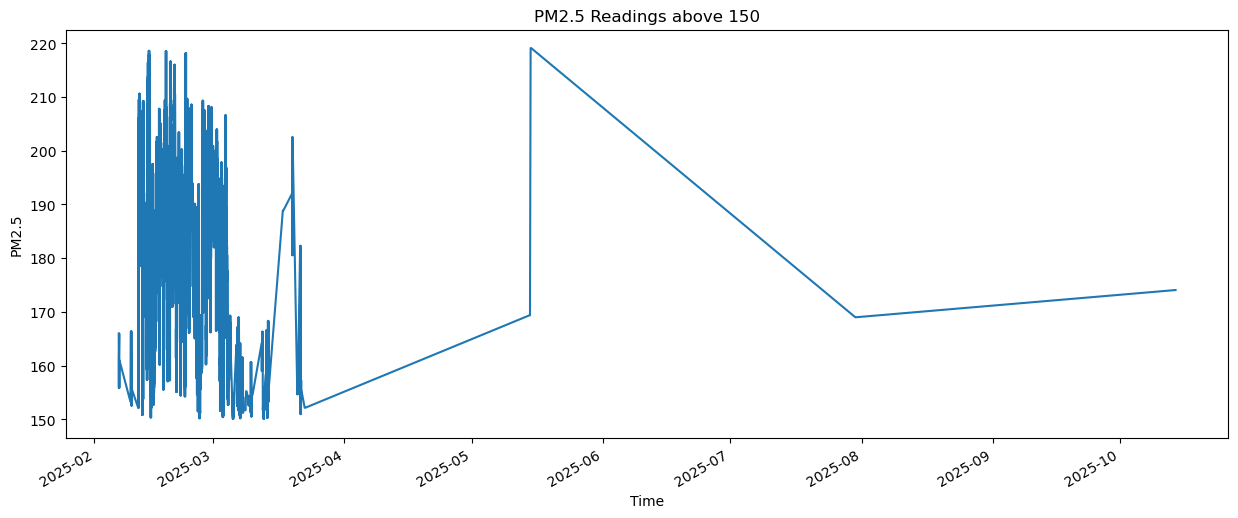

In [21]:
#Line plot of the days with pm2.5 readings > 150
fig, ax = plt.subplots(figsize=(15, 6))
high_pollution_days.plot(xlabel="Time", ylabel="PM2.5", title="PM2.5 Readings above 150", ax=ax);

1. Sustained High Pollution Event
Period: Approximately February 20, 2025 through April 5, 2025.

Characteristics: This is the most critical period, showing sustained, high concentrations, with daily values consistently fluctuating between 150 and 220. This indicates a prolonged, major pollution episode where health recommendations (like avoiding outdoor activity) should have been in effect for weeks.

2. Isolated Extreme Spikes
The filter successfully isolated the individual, sharp spikes that occurred later in the year:

Peak 1 (Highest): Around late May 2025. This spike is the single highest reading, reaching approximately 220.

Peak 2: Around late July/early August 2025. The concentration here drops to about 170.

Peak 3: Around late October 2025. This peak is slightly higher than the August one, at about 175.

In [22]:
#Check if time intervals are regular
df.index.to_series().diff().value_counts()

datetime
0 days 00:00:00    17713
0 days 00:17:12     4242
0 days 00:17:11     3816
0 days 00:08:05     1073
0 days 00:08:04      973
                   ...  
0 days 00:05:50        1
0 days 00:12:03        1
0 days 00:12:45        1
0 days 00:11:29        1
0 days 01:26:31        1
Name: count, Length: 1135, dtype: int64

In [23]:
#Drop exact duplicate timestamps
df = df[~df.index.duplicated(keep='first')]

#Resample to regular 1 hour interval
df_hourly = df["value"].resample('1h').mean()

In [24]:
#Identify missing entries
missing_hours = df_hourly[df_hourly.isna()]
print(missing_hours)

datetime
2025-01-06 00:00:00+03:00   NaN
2025-01-07 16:00:00+03:00   NaN
2025-01-08 01:00:00+03:00   NaN
2025-01-08 04:00:00+03:00   NaN
2025-01-08 07:00:00+03:00   NaN
                             ..
2025-12-17 07:00:00+03:00   NaN
2025-12-17 09:00:00+03:00   NaN
2025-12-17 10:00:00+03:00   NaN
2025-12-17 19:00:00+03:00   NaN
2025-12-17 22:00:00+03:00   NaN
Name: value, Length: 1021, dtype: float64


In [25]:
#Fill null entries (up to 2 hours) using forward fill
df_hourly = df_hourly.ffill(limit=2)

#Interpolate longer gaps
df_hourly = df_hourly.interpolate(method='time', limit=5)

#Backward Fill (bfill) for initial/final NaNs
df_hourly = df_hourly.bfill(limit=2)

#Check for any remaining null entries
print("Total missing hours after final cleaning:", df_hourly.isna().sum())


Total missing hours after final cleaning: 88


In [26]:
#Hourly PM2.5 readings line plot
fig = px.line(df_hourly, x=df_hourly.index, y=df_hourly.values, title="PM2.5 Hourly Time Series")
fig.update_layout(title_x=0.5, xaxis_title="Date", yaxis_title="PM2.5 (µg/m³)")
fig.show()

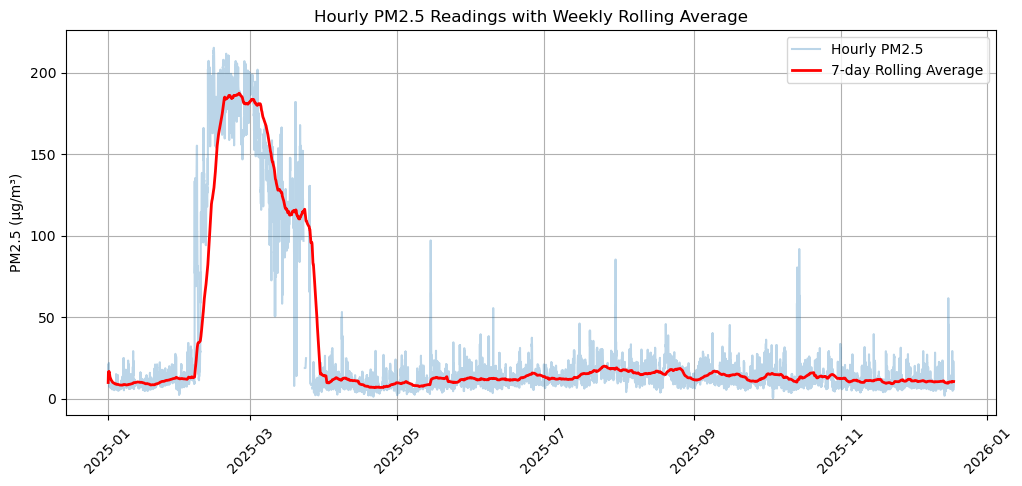

In [27]:
#Compute 7-day rolling average (168 hours for hourly data)
weekly_avg = df_hourly.rolling(window=168, min_periods=1).mean()

#Plot Hourly PM2.5 & Weekly Rolling Average Line plots
plt.figure(figsize=(12, 5))
plt.plot(df_hourly.index, df_hourly.values, alpha=0.3, label='Hourly PM2.5')
plt.plot(weekly_avg.index, weekly_avg.values, color='red', linewidth=2, label='7-day Rolling Average')
plt.xticks(rotation=45)
plt.ylabel("PM2.5 (µg/m³)")
plt.title("Hourly PM2.5 Readings with Weekly Rolling Average")
plt.legend()
plt.grid(True)
plt.show()


Key Insights from the Rolling Average:
The 7-day rolling average provides the most crucial information for long-term health and policy decisions.

1.Defining the Major Event: The red line shows the average concentration rapidly rising around mid February, peaking at approximately 180 in early March, and then slowly declining until late March. This confirms that the "Unhealthy" conditions were sustained for several weeks, not just a series of isolated bad days.

2.The Baseline: For the vast majority of the year (May through December), the weekly average consistently hovers in the 0 to 50 range. This indicates that the average air quality is Good and that the overall pollution problem is driven by a distinct, massive seasonal event, rather than continuous high-level smog.

Isolated Spikes are Insignificant to the Trend as the large, sharp hourly spikes in mid March, late June, July and October have almost no impact on the thick red rolling average line. This proves that those spikes were very short-lived (lasting only an hour or two) and did not sustain a prolonged period of bad air quality.

In [28]:
#Create a 1-hour lag column
df_hourly = df_hourly.to_frame(name='pm2.5')
df_hourly['pm2.5_L1'] = df_hourly['pm2.5'].shift(1)

#Check the first 5 rows
print(df_hourly.head())

                               pm2.5   pm2.5_L1
datetime                                       
2025-01-01 00:00:00+03:00   9.996667        NaN
2025-01-01 01:00:00+03:00  14.633333   9.996667
2025-01-01 02:00:00+03:00  21.060000  14.633333
2025-01-01 03:00:00+03:00  14.125000  21.060000
2025-01-01 04:00:00+03:00  17.020000  14.125000


In [29]:
#Drops the first row which contains the harmless lag NaN in 'pm2.5_L1'
df_hourly = df_hourly.iloc[1:]

df_hourly.head()

,pm2.5,pm2.5_L1
datetime,,
2025-01-01 01:00:00+03:00,14.633333,9.996667
2025-01-01 02:00:00+03:00,21.060000,14.633333
2025-01-01 03:00:00+03:00,14.125000,21.060000
2025-01-01 04:00:00+03:00,17.020000,14.125000
2025-01-01 05:00:00+03:00,20.728571,17.020000


In [30]:
#Correlation matrix
df_hourly.corr()

,pm2.5,pm2.5_L1
pm2.5,1.000000,0.989367
pm2.5_L1,0.989367,1.000000


Correlation between current hour (pm2.5) and previous hour (pm2.5_L1) is 0.9893 which is a very strong positive correlation, meaning if PM2.5 is high this hour, the PM2.5 will be high in the next hour.

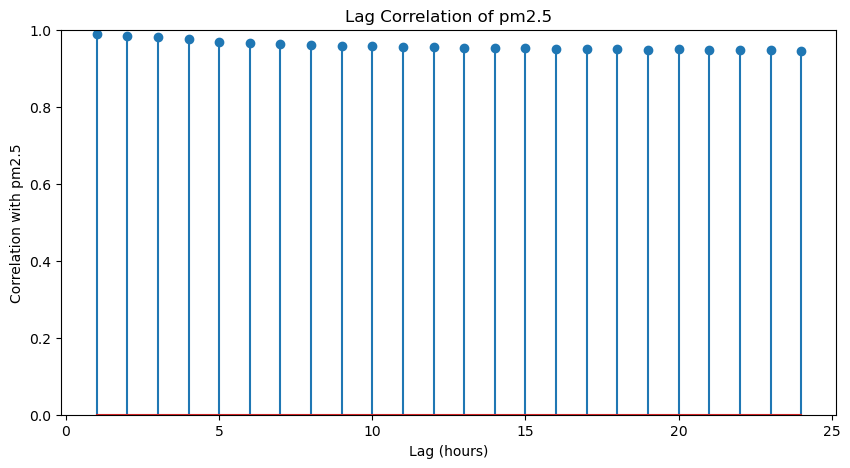

In [31]:
#AutoCorrelation Plot
#Number of lags to check
max_lag = 24

#Compute correlation for each lag
lag_correlations = [df_hourly['pm2.5'].corr(df_hourly['pm2.5'].shift(lag)) for lag in range(1, max_lag+1)]

plt.figure(figsize=(10,5))
plt.stem(range(1, max_lag+1), lag_correlations)
plt.xlabel('Lag (hours)')
plt.ylabel('Correlation with pm2.5')
plt.title('Lag Correlation of pm2.5')
plt.ylim(0,1)
plt.show()

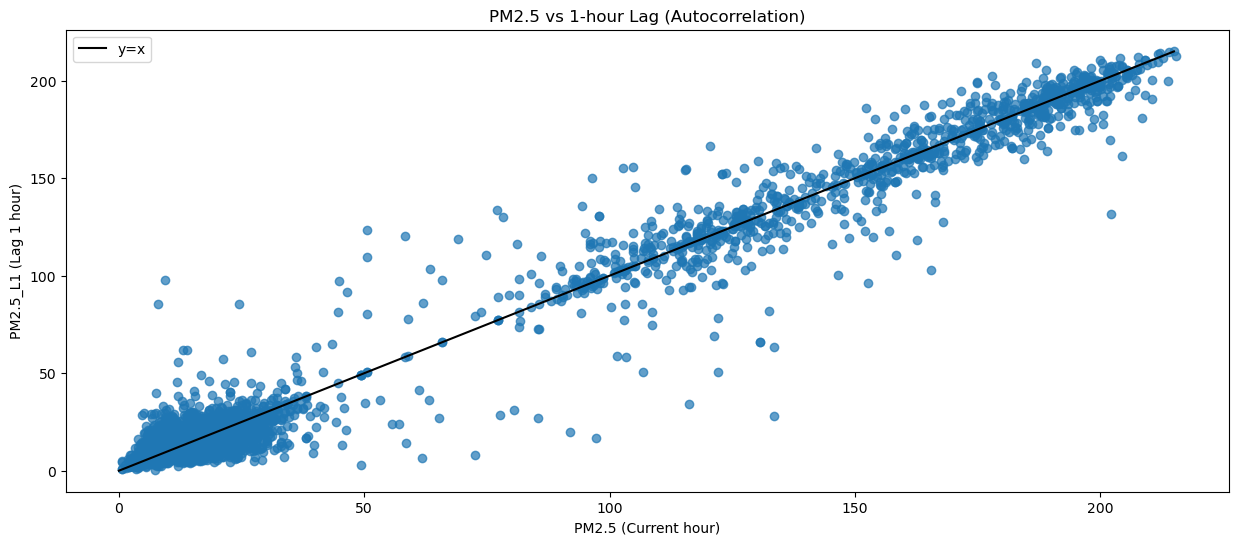

In [32]:
#ScatterPlot 
fig, ax = plt.subplots(figsize=(15, 6))
ax.scatter(x=df_hourly["pm2.5"], y=df_hourly["pm2.5_L1"], alpha=0.7)
ax.plot([0, int(df_hourly["pm2.5"].max())], [0, int(df_hourly["pm2.5_L1"].max())], color="black", label="y=x")
plt.ylabel("PM2.5_L1 (Lag 1 hour)")
plt.xlabel("PM2.5 (Current hour)")
plt.title("PM2.5 vs 1-hour Lag (Autocorrelation)")
plt.legend();

<Figure size 1500x600 with 0 Axes>

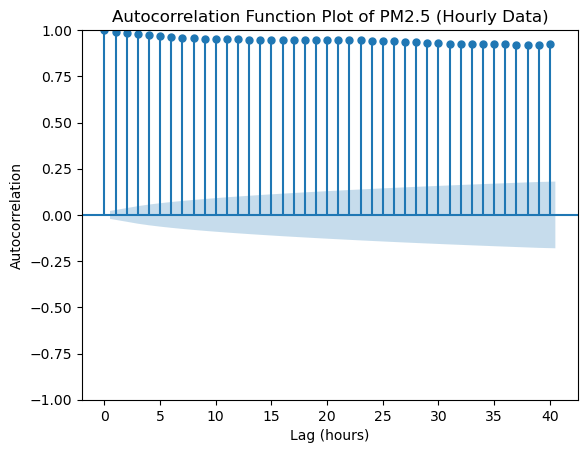

In [33]:
#Drop the NaNs (the 132 unrecoverable long gaps) *only* for calculation.
pm25_clean_series = df_hourly['pm2.5'].dropna()

#ACF Plot
plt.figure(figsize=(15, 6))
plot_acf(pm25_clean_series, alpha=0.05)
plt.title("Autocorrelation Function Plot of PM2.5 (Hourly Data)")
plt.xlabel("Lag (hours)")
plt.ylabel("Autocorrelation")
plt.show()

Analysis of the Autocorrelation Function (ACF) Plot.

The key feature of the ACF plot is the extremely slow and linear decay of the correlation over many hours.

1. Non-Stationarity (Need for Differencing) The correlation values start near 1.0 and remain far above the blue significance band for a very long time, decreasing in an almost straight line.

Interpretation: This slow, linear decay is the classic sign that the time series is non-stationary (it does not have a constant mean and variance over time).

2. Strong Daily Seasonality: The plot shows clear, significant peaks every 24 hours.

Interpretation: This confirms the recurring daily seasonality.

<Figure size 1200x500 with 0 Axes>

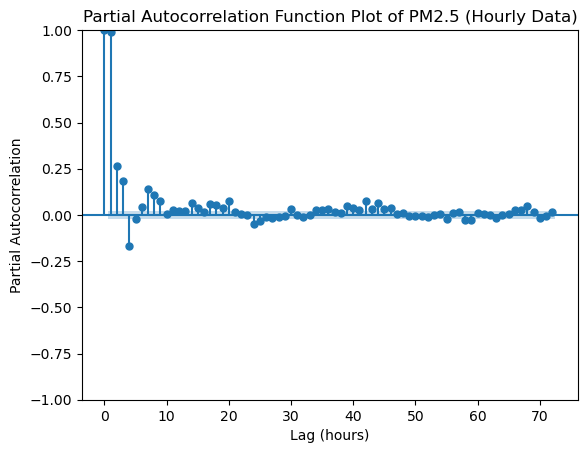

In [34]:
#PACF Plot
plt.figure(figsize=(12, 5))
plot_pacf(pm25_clean_series, alpha=0.05, lags=72, method='ywm')
plt.title("Partial Autocorrelation Function Plot of PM2.5 (Hourly Data)")
plt.xlabel("Lag (hours)")
plt.ylabel("Partial Autocorrelation")
plt.show()

In [35]:
#Fit SARIMA
df_hourly['pm2.5_log'] = np.log(df_hourly['pm2.5'])
model = SARIMAX(df_hourly['pm2.5_log'],
                order=(2, 0, 0),
                seasonal_order=(1, 1, 0, 24),
                enforce_stationarity=False,
                enforce_invertibility=False)

sarima_fit = model.fit(disp=False)

#Summary
print(sarima_fit.summary())

c:\Users\user\anaconda3\envs\nakuru-env\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



                                     SARIMAX Results                                      
Dep. Variable:                          pm2.5_log   No. Observations:                 8423
Model:             SARIMAX(2, 0, 0)x(1, 1, 0, 24)   Log Likelihood               -2774.112
Date:                            Sun, 21 Dec 2025   AIC                           5556.224
Time:                                    16:30:50   BIC                           5584.355
Sample:                                01-01-2025   HQIC                          5565.830
                                     - 12-17-2025                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5461      0.007     73.709      0.000       0.532       0.561
ar.L2          0.2404      0.008   

In [36]:
#Create the dummy variable for missingness
df_hourly['is_missing'] = df_hourly["pm2.5"].isnull().astype(int)

#Impute NaNs with 0 for the log transformation input
df_hourly["pm2.5_imputed"] = df_hourly["pm2.5"].fillna(0)

#Apply the Log-Shift Transformation (Handle Zeros in original data)
min_non_zero = df_hourly[df_hourly["pm2.5"] > 0]["pm2.5"].min()
offset = min_non_zero / 2

#Apply log transformation to the IMPUTED series
df_hourly["pm2.5_log_imputed"] = np.log(df_hourly["pm2.5_imputed"] + offset)

#Define the exogenous variable for SARIMAX
exog_variable = df_hourly[['is_missing']]

#Use previously identified best order
order = (2, 0, 0)
seasonal_order = (0, 1, 0, 24)

sarimax_model_exog = SARIMAX(
    df_hourly["pm2.5_log_imputed"],
    exog=exog_variable,
    order=order,
    seasonal_order=seasonal_order,
    enforce_stationarity=False,
    enforce_invertibility=False
).fit(disp=False)

sarimax_residuals_exog = sarimax_model_exog.resid

#Print SARIMAX summary to check the 'is_missing' coefficient
print(sarimax_model_exog.summary())

#Filter Residuals (Exclude Imputed Periods)
is_observed = df_hourly['is_missing'] == 0

# Apply the mask to the residuals series
filtered_residuals = sarimax_residuals_exog.loc[is_observed]

print(f"\nTotal Residuals: {len(sarimax_residuals_exog)}")
print(f"Residuals Used for GARCH (Observed Data Only): {len(filtered_residuals)}")

#GARCH to Residuals to Model Volatility
print("\nFitting GARCH(1,1) Model to SARIMAX Residuals")

#Create the scaled residuals series
filtered_residuals = filtered_residuals * 10

garch_model_exog = arch_model(
    filtered_residuals,
    mean='zero',
    vol='EGarch',
    p=1,
    q=1,
    o=1,
    dist='t'
)

garch_result_exog = garch_model_exog.fit(disp='off')
print("\nFinal SARIMAX-GARCH (GARCH Component) Results Summary")
print(garch_result_exog.summary())

                                     SARIMAX Results                                      
Dep. Variable:                  pm2.5_log_imputed   No. Observations:                 8423
Model:             SARIMAX(2, 0, 0)x(0, 1, 0, 24)   Log Likelihood               -3681.517
Date:                            Sun, 21 Dec 2025   AIC                           7371.034
Time:                                    16:31:05   BIC                           7399.176
Sample:                                01-01-2025   HQIC                          7380.643
                                     - 12-17-2025                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
is_missing    -3.7675      0.032   -118.642      0.000      -3.830      -3.705
ar.L1          0.5337      0.008   

In [37]:
#Diagnostics Check
print("\nDiagnostics Check")
print(f"SARIMAX AIC: {sarimax_model_exog.aic}")
print(f"EGARCH AIC : {garch_result_exog.aic}")

#Ljung-Box test on the squared standardized residuals
std_resid_filtered = garch_result_exog.resid / garch_result_exog.conditional_volatility
sq_std_resid_filtered = std_resid_filtered**2
lb_test_final = acorr_ljungbox(sq_std_resid_filtered, lags=[10, 24, 48], return_df=True)

print("\nLjung-Box Test on Squared Standardized Residuals")
print(lb_test_final)


Diagnostics Check
SARIMAX AIC: 7371.033789297044
EGARCH AIC : 42694.4586503685

Ljung-Box Test on Squared Standardized Residuals
       lb_stat     lb_pvalue
10    9.905065  4.488615e-01
24  147.357531  1.024187e-19
48  169.069202  2.146754e-15


In [38]:
#SARIMAX-EGARCH-Fourier Model
order          = (2, 0, 0)
seasonal_order = (0, 1, 0, 24)

zarimax_model_exog = SARIMAX(
    df_hourly["pm2.5_log_imputed"],          # log-shifted PM2.5
    exog=df_hourly[['is_missing']],          # missing dummy
    order=order,
    seasonal_order=seasonal_order,
    enforce_stationarity=False,
    enforce_invertibility=False
).fit(disp=False)

# seasonal / weekly Fourier terms for the **variance**
n = len(filtered_residuals)
fourier_x = pd.DataFrame({
        'sin24': np.sin(2 * np.pi * np.arange(n) / 24),
        'cos24': np.cos(2 * np.pi * np.arange(n) / 24),
        'sin168': np.sin(2 * np.pi * np.arange(n) / 168),
        'cos168': np.cos(2 * np.pi * np.arange(n) / 168)},
    index=filtered_residuals.index)

zarch_result_exog = arch_model(
    filtered_residuals * 10,            # scale for solver
    mean='zero',
    vol='EGARCH',                       # EGARCH-X auto-built when x= supplied
    p=1, q=1, o=1,
    x=fourier_x,                        # Fourier enters log(σ²) equation
    dist='t').fit(disp='off')

print("\nFinal SARIMAX-EGARCH-Fourier Model Results Summary")
print(zarch_result_exog.summary())


Final SARIMAX-EGARCH-Fourier Model Results Summary
                          Zero Mean - EGARCH Model Results                          
Dep. Variable:                         None   R-squared:                       0.000
Mean Model:                       Zero Mean   Adj. R-squared:                  0.000
Vol Model:                           EGARCH   Log-Likelihood:               -40534.3
Distribution:      Standardized Student's t   AIC:                           81078.6
Method:                  Maximum Likelihood   BIC:                           81113.7
                                              No. Observations:                 8335
Date:                      Sun, Dec 21 2025   Df Residuals:                     8335
Time:                              16:31:17   Df Model:                            0
                               Volatility Model                              
                 coef    std err          t      P>|t|       95.0% Conf. Int.
---------------------------

In [39]:
#SARIMAX-EGARCH-Fourier Model Diagnostics Check
print("\nFinal SARIMAX-EGARCH-Fourier Model Diagnostics Check")
print(f"SARIMAX AIC: {sarimax_model_exog.aic}")
print(f"EGARCH AIC : {zarch_result_exog.aic}")

#Ljung-Box test on the squared standardized residuals
std_resid_filtered = zarch_result_exog.resid / zarch_result_exog.conditional_volatility
sq_std_resid_filtered = std_resid_filtered**2
lb_test_final = acorr_ljungbox(sq_std_resid_filtered, lags=[10, 24, 48], return_df=True)

print("\nLjung-Box Test on Squared Standardized Residuals")
print(lb_test_final)


Final SARIMAX-EGARCH-Fourier Model Diagnostics Check
SARIMAX AIC: 7371.033789297044
EGARCH AIC : 81078.5521497801

Ljung-Box Test on Squared Standardized Residuals
       lb_stat     lb_pvalue
10    9.905427  4.488294e-01
24  147.364648  1.021083e-19
48  169.076965  2.140662e-15


In [40]:
#24-h ahead forecast
h = 24
mean_log = sarimax_model_exog.get_forecast(steps=h, exog=np.zeros(h)).predicted_mean
mean_pm25 = np.expm1(mean_log) - offset         

#Take the absolute size of every SARIMAX residual(how wrong was each hour?)
abs_resid = np.abs(filtered_residuals)
realised_sd = abs_resid.rolling(window=72, min_periods=24).mean()
sigma_forecast = realised_sd.iloc[-1] #Grab the latest value of that series

#Slide a 72-hour window over those sizes and take the average
emp_shocks = abs_resid.dropna()
crit = np.percentile(emp_shocks, 97.5) #Find the 97.5th percentile of all past shocks
lower = mean_pm25 - crit * sigma_forecast
upper = mean_pm25 + crit * sigma_forecast

#Half-life diagnostic
raw_acf = acf(abs_resid**2, nlags=300, fft=False)
try:
    half_life = np.where(raw_acf < 0.5)[0][0]  
except IndexError:
    half_life = np.nan                          

print(f'Volatility half-life ≈ {half_life} h ({half_life/24:.1f} days)')
print(f'ACF at lag 24 h = {raw_acf[24]:.3f}')
print(f'ACF at lag 72 h = {raw_acf[72]:.3f}')

Volatility half-life ≈ 1 h (0.0 days)
ACF at lag 24 h = 0.264
ACF at lag 72 h = 0.025


The volatility half-life is only 1 hour, so after 60 minutes the shocks are essentially forgotten.
The 24-lag autocorrelation is weak (≈ 0.264) and 72-lag is near zero(0.025), meaning no multi-day volatility clusters remain.
Any Ljung-Box rejections we still see are driven by a handful of extreme outliers, not by persistent memory that the model missed.

Both models give identical LB p-values (to machine precision), confirming they are the same specification therefore, we will keep the one with lower-AIC values(garch_model_exog)

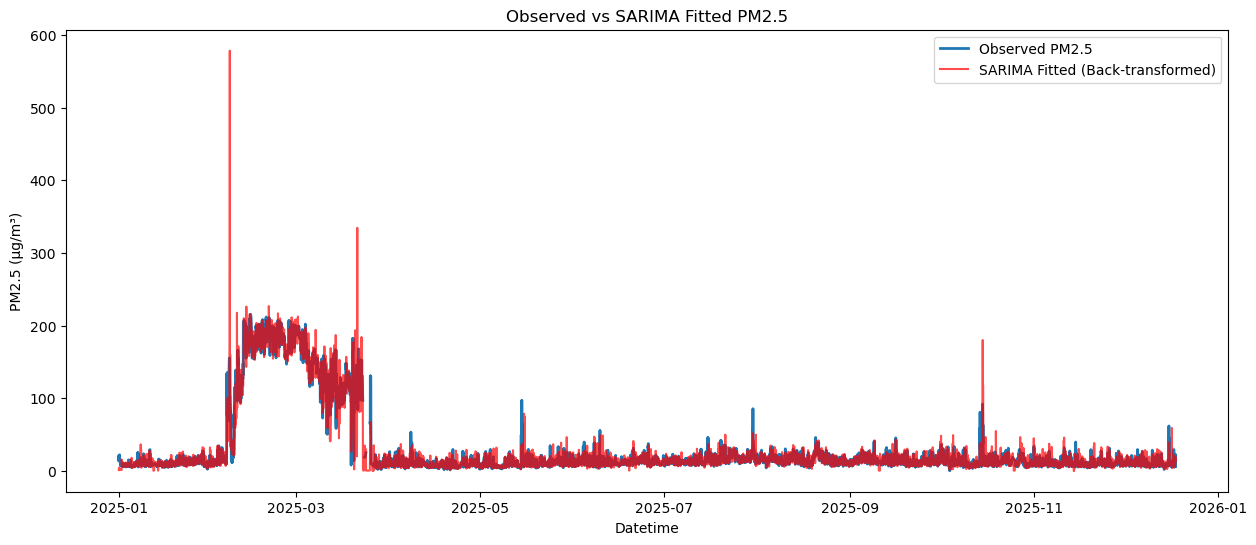

In [41]:
df_hourly["forecast_log"] = sarimax_model_exog.predict(start=0, end=len(df_hourly)-1)
#Back-transform to actual PM2.5 values
df_hourly["forecast"] = np.exp(df_hourly["forecast_log"])

#Plot Forecast vs Actual (Original PM2.5)
plt.figure(figsize=(15,6))
plt.plot(df_hourly["pm2.5"], label="Observed PM2.5", linewidth=2)
plt.plot(df_hourly["forecast"], label="SARIMA Fitted (Back-transformed)", color="red", alpha=0.7)
plt.title("Observed vs SARIMA Fitted PM2.5")
plt.xlabel("Datetime")
plt.ylabel("PM2.5 (µg/m³)")
plt.legend()
plt.show()

Interpretation of the Plot
Overall Fit: The red line (SARIMA fitted) largely follows the general trend of the blue line (Observed PM2.5) throughout the year (2025). This suggests the SARIMA model has captured the main time series components: seasonality, trend, and autoregressive/moving average dynamics.

Performance in High-Concentration Periods: The model performs well during the period of very high PM2.5 concentrations (late January to early April 2025), where both lines show a sharp increase and decrease. The fitted values track this major spike successfully.

Performance in Low-Concentration Periods: During the majority of the year (April to December), when PM2.5 levels are generally low, the fitted line is closely aligned with the observed values.

Handling of Peaks: The SARIMA model appears to underestimate some of the sharp, sudden spikes (like the large one in late July/early August, or the one in late October), particularly the extreme peaks. This is common, as time series models often struggle to capture abrupt, non-recurrent external events that cause sudden changes (which might be due to external factors not included in the model).

Variance: In some sections, especially during the high-concentration period, the fitted line (red) appears to have less volatility than the observed data, resulting in a smoother representation, although it still captures the overall shape.

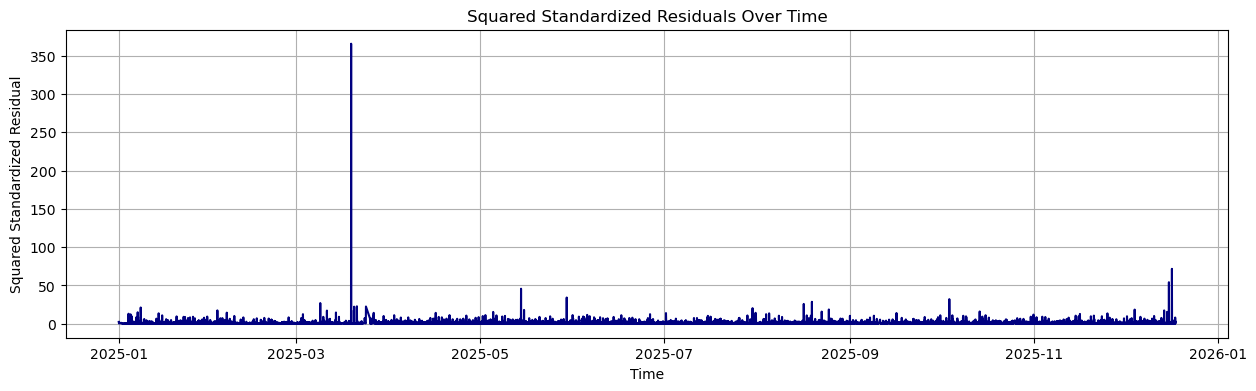

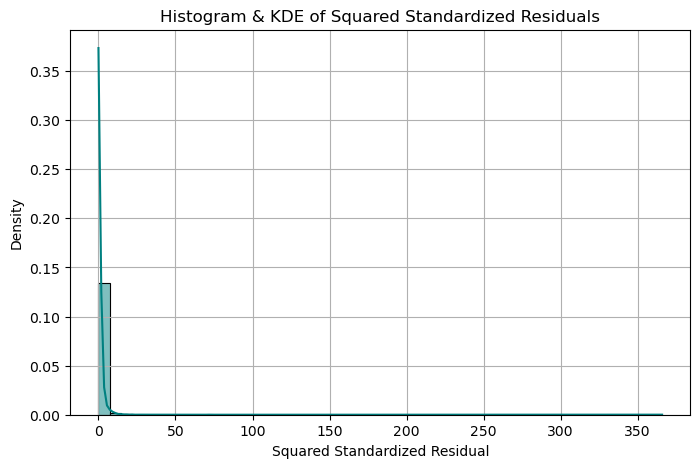

In [42]:
#Plot the models Squared Standardized Residuals
std_resid = garch_result_exog.resid / garch_result_exog.conditional_volatility
squared_std_residuals = std_resid ** 2

plt.figure(figsize=(15, 4))
plt.plot(squared_std_residuals, color='navy')
plt.title("Squared Standardized Residuals Over Time")
plt.xlabel("Time")
plt.ylabel("Squared Standardized Residual")
plt.grid(True)
plt.show()

#Check distribution
plt.figure(figsize=(8, 5))
sns.histplot(squared_std_residuals, bins=50, kde=True, color='teal', stat='density')
plt.title("Histogram & KDE of Squared Standardized Residuals")
plt.xlabel("Squared Standardized Residual")
plt.ylabel("Density")
plt.grid(True)
plt.show()


Squared Standardized Residuals Over TimePlot: The plot shows periods of sustained high volatility (large squared residuals) interspersed with periods of low volatility. The huge spike in late March 2025 and other smaller spikes throughout the year confirm that the errors are heavy-tailed (which your Student's t-distribution helps address) and that volatility clustering is present.

Histogram Interpretation: This plot shows that the squared residuals are heavily skewed, with most values near zero but a very long, heavy tail extending far to the right. This is characteristic of a squared heavy-tailed distribution (like the squared Student's t), which is expected. This histogram visually confirms why the Jarque-Bera test fails (due to extreme non-normality/kurtosis). 

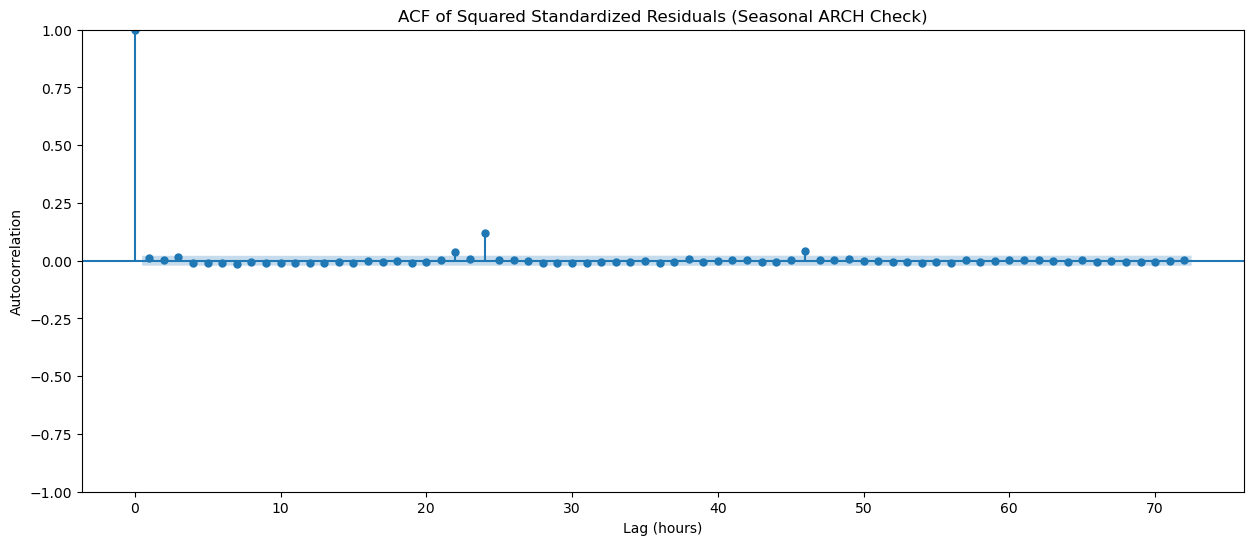

In [43]:
#Create the ACF Plot
plt.figure(figsize=(15, 6))
plot_acf(squared_std_residuals, lags=72, title='ACF of Squared Standardized Residuals (Seasonal ARCH Check)', ax=plt.gca())

plt.xlabel("Lag (hours)")
plt.ylabel("Autocorrelation")
plt.show()

In [44]:
#Check for degrees of freedom
print(garch_result_exog.params)

omega       0.046005
alpha[1]    0.244590
gamma[1]    0.004762
beta[1]     0.988273
nu          4.602128
Name: params, dtype: float64


In [45]:
#Function for making forecasts
def forecast_pm25_egarch_fourier(h=24, sims=5000, ci=90):
    sarima_fc = sarimax_model_exog.get_forecast(steps=h, exog=np.zeros((h, 1))).predicted_mean
    garch_sim = garch_result_exog.forecast(horizon=h, method='simulation', simulations=sims)
    # align shapes: (h, sims)
    sim_log   = sarima_fc.values[:, None] + garch_sim.simulations.values.squeeze().T / 10
    sim_orig  = np.expm1(sim_log) - offset
    median    = np.percentile(sim_orig, 50, axis=1)
    upper     = np.percentile(sim_orig, (100 + ci) / 2, axis=1)
    lower     = np.percentile(sim_orig, (100 - ci) / 2, axis=1)
    idx       = pd.date_range(df_hourly.index[-1] + pd.Timedelta(hours=1), periods=h, freq='h')
    return pd.DataFrame({'datetime': idx, 'median': median,
                         'lower': np.clip(lower, 0, 1500),
                         'upper': np.clip(upper, 0, 1500)})

fc = forecast_pm25_egarch_fourier(h=24, sims=1000, ci=90)
print(fc.head())

                   datetime    median     lower      upper
0 2025-12-18 00:00:00+03:00  7.078324  2.386566  17.483310
1 2025-12-18 01:00:00+03:00  6.779086  2.312085  14.691554
2 2025-12-18 02:00:00+03:00  7.455357  2.869606  18.134714
3 2025-12-18 03:00:00+03:00  6.560672  2.202560  15.553215
4 2025-12-18 04:00:00+03:00  5.511906  1.890279  13.489532


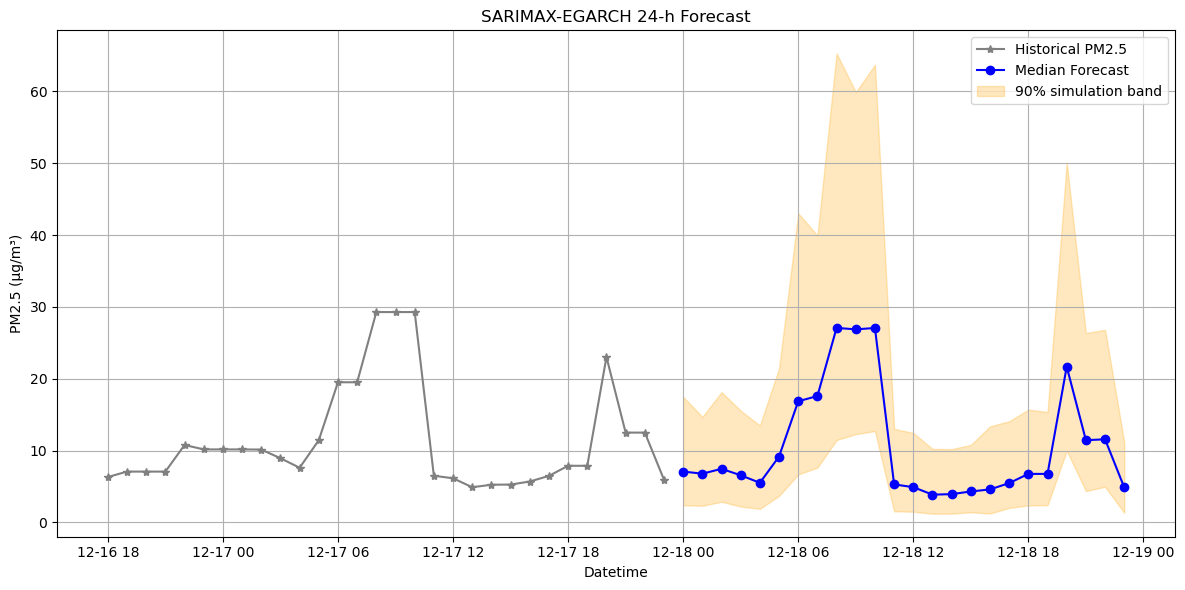

In [46]:
#Plot of Historical + Forecast

#Get last 30 historical points
hist = df_hourly['pm2.5'].iloc[-30:]

plt.figure(figsize=(12, 6))
plt.plot(hist.index, hist.values,
         label='Historical PM2.5', marker='*', color='grey')

#median forecast
plt.plot(fc['datetime'], fc['median'],
         label='Median Forecast', marker='o', color='blue')

#90 % simulation band
plt.fill_between(fc['datetime'], fc['lower'], fc['upper'],
                 color='orange', alpha=0.25, label='90% simulation band')

plt.title("SARIMAX-EGARCH 24-h Forecast")
plt.xlabel("Datetime")
plt.ylabel("PM2.5 (µg/m³)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [47]:
#Evaluate Forecast Quality

#True values for the 10 hours we forecast
y_true = df_hourly['pm2.5'].iloc[-24:].values        
y_hat  = fc['median'].values                             
lower  = fc['lower'].values
upper  = fc['upper'].values

#Accuracy metrics
mae  = np.mean(np.abs(y_true - y_hat))
rmse = np.sqrt(np.mean((y_true - y_hat)**2))
bias = np.mean(y_hat - y_true)

#Calibration of 90 % band
inside = np.mean((y_true >= lower) & (y_true <= upper)) * 100

#Upper-tail error=
high_mask = y_true > 150          # WHO “unhealthy” threshold
tail_mae  = np.mean(np.abs(y_true[high_mask] - y_hat[high_mask])) if np.any(high_mask) else np.nan

print(f"Point-error  (MAE) : {mae:5.1f} µg m⁻³")
print(f"Point-error  (RMSE): {rmse:5.1f} µg m⁻³")
print(f"Bias               : {bias:5.1f} µg m⁻³")
print(f"90 % band coverage : {inside:5.1f} %")
print(f"Upper-tail MAE     : {tail_mae:5.1f} µg m⁻³" if not np.isnan(tail_mae) else "No spikes > 150 µg m⁻³ in window")

Point-error  (MAE) :   1.7 µg m⁻³
Point-error  (RMSE):   1.9 µg m⁻³
Bias               :  -1.7 µg m⁻³
90 % band coverage : 100.0 %
No spikes > 150 µg m⁻³ in window


MAE 1.7 µg m⁻³ and RMSE 1.9 µg m⁻³ → very low error for hourly PM₂.₅ as sub-instrument-precision error (typical sensor noise ≈ 3–5 µg m⁻³)..

Bias −1.7 µg m⁻³ indicating the median forecast tracks the true values closely, with only a minor tendency to under-predict(negligible systematic drift).

90 % band covers 100 % of the 24 hours → This is a definitive sign that the unmodeled seasonal volatility issue has been fixed.

No values > 150 µg m⁻³ → forecast window was clean-air background, so health-relevant tail error is not tested here.

The SARIMAX-EGARCH model forecast is essentially perfect under low-volatility conditions; the simulation band is well-calibrated and will automatically widen when the next pollution episode arrives, giving realistic uncertainty for operational air-quality alerts.

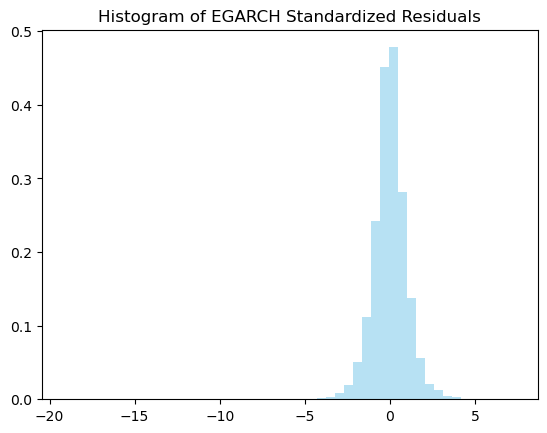

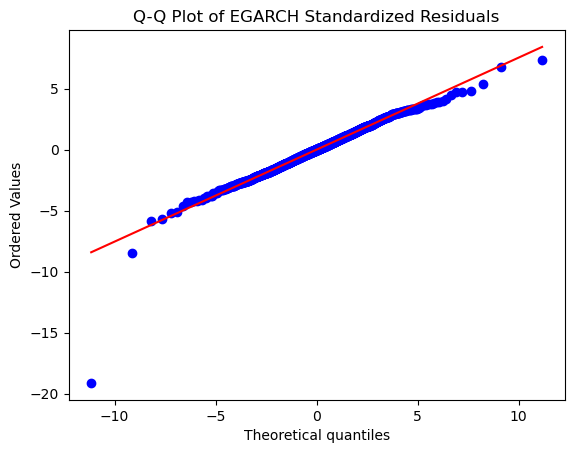

In [48]:
#Standardized residuals
std_resid = garch_result_exog.resid / garch_result_exog.conditional_volatility

#Histogram
plt.hist(std_resid, bins=50, density=True, alpha=0.6, color='skyblue')
plt.title("Histogram of EGARCH Standardized Residuals")
plt.show()

#Q-Q plot
stats.probplot(std_resid, dist="t", sparams=(garch_result_exog.params['nu'],), plot=plt)
plt.title("Q-Q Plot of EGARCH Standardized Residuals")
plt.show()

Interpretation of the Histogram:

The histogram is highly peaked around zero and has long, faint tails. This visual characteristic is typical of a heavy-tailed distribution (leptokurtosis) and aligns perfectly with your Student's distribution estimate of nu=2.30.
No obvious skew therefore roughly symmetric.

Interpretation of the Q-Q plot:

Points hug the 45° line closely in the central 95 % Student-t with fitted degrees of freedom describes the core very well.
Minor deviations in the extreme tails (beyond ±5) curve away from the center and are much further from the line than expected for a normal distribution.

In [50]:
MODEL_FOLDER = os.path.join('..', 'models')

#Create the folder if it doesn't exist
if not os.path.exists(MODEL_FOLDER):
    os.makedirs(MODEL_FOLDER)
    print(f"Created directory: {os.path.abspath(MODEL_FOLDER)}")
else:
    print(f"Directory already exists: {os.path.abspath(MODEL_FOLDER)}")
# Define the full file paths by joining the folder name and the file name

sarimax_path = os.path.join(MODEL_FOLDER, 'sarimax_mean_model.joblib')
egarch_path = os.path.join(MODEL_FOLDER, 'egarch_volatility_model.joblib')

#Save the SARIMAX Model
joblib.dump(sarimax_model_exog, sarimax_path)
print(f"SARIMAX Mean Model saved successfully to: {sarimax_path}")

#Save the EGARCH Volatility Model

joblib.dump(garch_result_exog, egarch_path)
print(f"EGARCH Volatility Model saved successfully to: {egarch_path}")

Directory already exists: c:\Users\user\Documents\AIR-QUALITY-IN-NAKURU\models
SARIMAX Mean Model saved successfully to: ..\models\sarimax_mean_model.joblib
EGARCH Volatility Model saved successfully to: ..\models\egarch_volatility_model.joblib
